# Predict Future Sales

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
import datetime
warnings.filterwarnings("ignore")

import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

In [ ]:
sales=pd.read_csv("/content/drive/My Drive/Colab Notebooks/Summer Internship/data/sales_train_v2.csv")
item_cat=pd.read_csv("/content/drive/My Drive/Colab Notebooks/Summer Internship/data/item_categories.csv")
item=pd.read_csv("/content/drive/My Drive/Colab Notebooks/Summer Internship/data/items.csv")
shops=pd.read_csv("/content/drive/My Drive/Colab Notebooks/Summer Internship/data/shops.csv")
test=pd.read_csv("/content/drive/My Drive/Colab Notebooks/Summer Internship/data/test.csv")
#formatting the date column correctly
sales.date=sales.date.apply(lambda x:datetime.datetime.strptime(x, '%d.%m.%Y'))

In [ ]:
monthly_sales=sales.groupby(["date_block_num","shop_id","item_id"])[
    "date","item_price","item_cnt_day"].agg({"date":["min",'max'],"item_price":"mean","item_cnt_day":"sum"})
monthly_sales.head(20)

date            item_price item_cnt_day
                                      min        max       mean          sum
date_block_num shop_id item_id                                              
0              0       32      2013-01-03 2013-01-31      221.0          6.0
                       33      2013-01-03 2013-01-28      347.0          3.0
                       35      2013-01-31 2013-01-31      247.0          1.0
                       43      2013-01-31 2013-01-31      221.0          1.0
                       51      2013-01-13 2013-01-31      128.5          2.0
                       61      2013-01-10 2013-01-10      195.0          1.0
                       75      2013-01-17 2013-01-17       76.0          1.0
                       88      2013-01-16 2013-01-16       76.0          1.0
                       95      2013-01-06 2013-01-06      193.0          1.0
                       96      2013-01-10 2013-01-10       70.0          1.0
                       98      2013-01-04 2013-01-31      268.0         25.0
                       111     2013-01-17 2013-01-17       89.0          1.0
                       149     2013-01-11 2013-01-28       99.0          3.0
                       151     2013-01-16 2013-01-16       75.0          1.0
                       153     2013-01-09 2013-01-09      258.0          1.0
                       198     2013-01-10 2013-01-10      112.0          1.0
                       210     2013-01-05 2013-01-25      118.0          2.0
                       282     2013-01-04 2013-01-04      109.0          1.0
                       306     2013-01-22 2013-01-22       59.0          1.0
                       351     2013-01-21 2013-01-21       89.0          1.0

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


######**Time Series**

In [ ]:
# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs



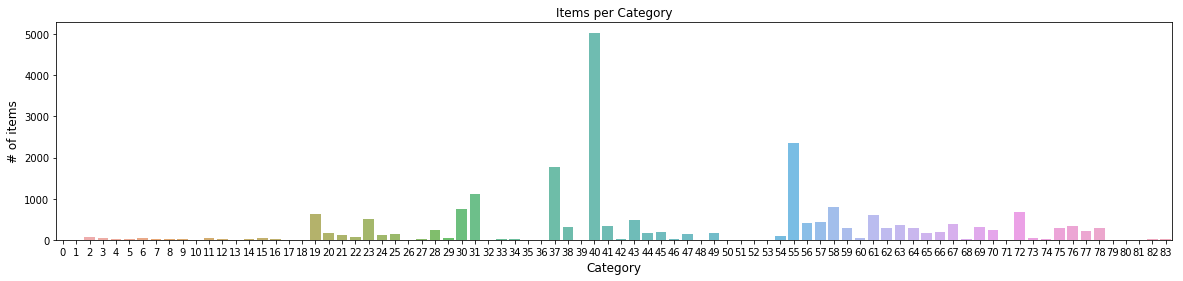

In [ ]:
# number of items per cat 
x=item.groupby(['item_category_id']).count()
x=x.sort_values(by='item_id',ascending=False)
x=x.iloc[0:].reset_index()
# #plot
plt.figure(figsize=(20,4))
ax= sns.barplot(x.item_category_id, x.item_id, alpha=0.8)
plt.title("Items per Category")
plt.ylabel('# of items', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.show()

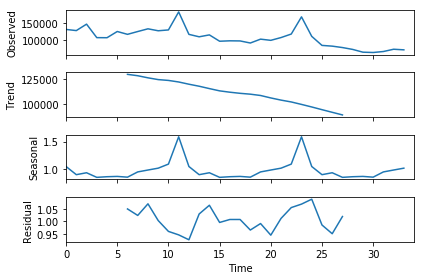

In [ ]:
ts=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="multiplicative")
#plt.figure(figsize=(16,12))
fig = res.plot()
fig.show()


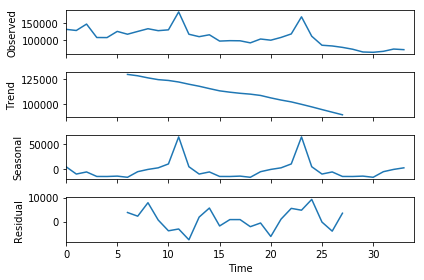

In [ ]:
# Additive model
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="additive")
#plt.figure(figsize=(16,12))
fig = res.plot()
#fig.show()

In [ ]:
from rpy2.robjects import r
def decompose(series, frequency, s_window, **kwargs):
    df = pd.DataFrame()
    df['date'] = series.index
    s = [x for x in series.values]
    length = len(series)
    s = r.ts(s, frequency=frequency)
    decomposed = [x for x in r.stl(s, s_window, **kwargs).rx2('time.series')]
    df['observed'] = series.values
    df['trend'] = decomposed[length:2*length]
    df['seasonal'] = decomposed[0:length]
    df['residual'] = decomposed[2*length:3*length]
    return df

In [ ]:
# Stationarity tests
def test_stationarity(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(ts)

Results of Dickey-Fuller Test:
Test Statistic                 -2.395704
p-value                         0.142953
#Lags Used                      0.000000
Number of Observations Used    33.000000
Critical Value (5%)            -2.954127
Critical Value (1%)            -3.646135
Critical Value (10%)           -2.615968
dtype: float64


In [ ]:
# to remove trend
from pandas import Series as Series
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced forecast
def inverse_difference(last_ob, value):
    return value + last_ob

In [ ]:
ts=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
new_ts=difference(ts,12)       # assuming the seasonality is 12 months long

test_stationarity(new_ts)

Results of Dickey-Fuller Test:
Test Statistic                 -3.270101
p-value                         0.016269
#Lags Used                      0.000000
Number of Observations Used    21.000000
Critical Value (5%)            -3.013098
Critical Value (1%)            -3.788386
Critical Value (10%)           -2.646397
dtype: float64


In [ ]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh',title=''):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title(title)
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

In [ ]:
#
# pick best order by aic 
# smallest aic value wins
best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(5)
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(new_ts.values, order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic: 472.99703 | order: (1, 1)


In [ ]:
# adding the dates to the Time-series as index
ts=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.index=pd.date_range(start = '2013-01-01',end='2015-10-01', freq = 'MS')
ts=ts.reset_index()
ts.head()

,index,item_cnt_day
0,2013-01-01,131479.0
1,2013-02-01,128090.0
2,2013-03-01,147142.0
3,2013-04-01,107190.0
4,2013-05-01,106970.0


## LSTM

In [ ]:
from nested_lstm import NestedLSTMCell, NestedLSTM

Using TensorFlow backend.


In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation
from keras.optimizers import Adam, SGD, RMSprop
from keras import backend as K

In [ ]:
model = Sequential()
model.add(NestedLSTM(40, input_shape=(33, 1), depth=2, dropout=0.0, recurrent_dropout=0.0))
model.add(Dense(1))

# The adam optimizer works pretty well, although you might try RMSProp as well
model.compile(loss='mse',
              optimizer='adam',
              metrics=['mean_squared_error'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
nested_lstm_1 (NestedLSTM)   (None, 40)                19680     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 41        
Total params: 19,721
Trainable params: 19,721
Non-trainable params: 0
_________________________________________________________________


In [ ]:
df = sales.groupby([sales.date.apply(lambda x: x.strftime('%Y-%m')),'item_id','shop_id']).sum().reset_index()

In [ ]:
df = df[['date','item_id','shop_id','item_cnt_day']]
df = df.pivot_table(index=['item_id','shop_id'], columns='date',values='item_cnt_day',fill_value=0).reset_index()
df.head()

date,item_id,shop_id,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10
0,0,54,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,55,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,2,54,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,3,54,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,54,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_test = pd.merge(test, df, on=['item_id','shop_id'], how='left')
df_test = df_test.fillna(0)
df_test.head()

,ID,shop_id,item_id,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10
0,0,5,5037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,3,5,5232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_test = df_test.drop(labels=['ID', 'shop_id', 'item_id'], axis=1)
df_test.head()

,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
TARGET = '2015-10'
y_train = df_test[TARGET]
X_train = df_test.drop(labels=[TARGET], axis=1)
X_train = X_train.as_matrix()
X_train = X_train.reshape((214200, 33, 1))

y_train = y_train.as_matrix()
y_train = y_train.reshape(214200, 1)



In [ ]:
X_test = df_test.drop(labels=['2013-01'],axis=1)
X_test = X_test.as_matrix()
X_test = X_test.reshape((214200, 33, 1))

In [ ]:
df_test = pd.merge(test, df, on=['item_id','shop_id'], how='left')
df_test = df_test.fillna(0)
df_test.head()

,ID,shop_id,item_id,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10
0,0,5,5037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,3,5,5232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#TODO: reduce batch size and increase number of epochs, see where it converges.
BATCH = 32
model.fit(X_train, y_train,
          batch_size=BATCH,
          epochs=50
         )

 78496/214200 [=========>....................] - ETA: 2:01 - loss: 6.6787 - mean_squared_error: 6.6787

KeyboardInterrupt: ignored

## SVM 

In [ ]:
from sklearn.svm import SVR
param1 = {'C': [1]}
grid = GridSearchCV(SVR(), param1, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
grid.fit(X_train[:, :,0], y_train)

In [ ]:
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor

def baseline_model():
     	# create model
    model = Sequential()
    model.add(Dense(20, input_dim=train_x.shape[1], kernel_initializer='uniform', activation='softplus'))
    model.add(Dense(1, kernel_initializer='uniform', activation = 'relu'))
         # Compile model
    model.compile(loss='mse', optimizer='Nadam', metrics=['mse'])
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

estimator = KerasRegressor(build_fn=baseline_model, verbose=1, epochs=5, batch_size = 55000)

estimator.fit(X_train, y_train)
y_pred = estimator.predict(X_test).clip(0., 20)

In [ ]:

#y_pred = model.predict(X_test).clip(0., 20.)

# Create the submission file and submit!
preds = pd.DataFrame(y_pred, columns=['item_cnt_month'])
preds.to_csv('submission.csv',index_label='ID')

## XGBoost

In [ ]:
from xgboost import XGBRegressor
param_test2 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch2 = GridSearchCV(estimator = XGBRegressor( learning_rate=0.1, n_estimators=140, max_depth=5,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8, nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch2.fit(X_train[:,:,0],y_train)
gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_

({'mean_fit_time': array([ 67.87353444,  68.93493514,  68.61840844, 102.86558833,
         105.81580358, 102.12595344, 143.61535621, 139.09164562,
         138.44113107, 197.76243033, 187.22770081, 168.2723546 ]),
  'mean_score_time': array([0.31470513, 0.26787758, 0.2737464 , 0.47155428, 0.4518199 ,
         0.39707079, 0.61045375, 0.55154457, 0.57740045, 0.77827339,
         0.75774102, 0.48601661]),
  'mean_test_score': array([-22.99133893, -32.94110343, -26.4109387 , -23.15005918,
         -33.98533607, -26.64262167, -22.93176231, -33.17889222,
         -28.26263064, -23.26515223, -33.47885322, -27.61283953]),
  'mean_train_score': array([-1.56161478, -1.96661732, -2.97177822, -1.50005276, -1.83940524,
         -2.84701468, -1.45624668, -1.77269025, -2.79164483, -1.41951007,
         -1.72896377, -2.69952295]),
  'param_max_depth': masked_array(data=[3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9],
               mask=[False, False, False, False, False, False, False, False,
                   